Implementation of initial VAE for band 11

In [ ]:
from pathlib import Path
import tqdm

In [ ]:
from google.colab import drive
%load_ext google.colab.data_table

ps_cl_repo_path = 'train11/'
content_path = f'/content/drive/MyDrive/{ps_cl_repo_path}'
data_path = './data/'

# Mounts notebook to drive
drive.mount('/content/drive/')

content_path = Path(content_path)

Mounted at /content/drive/


In [ ]:
# Import packages
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists('/content/drive/MyDrive/PS_VAE11/'):
    os.makedirs('/content/drive/MyDrive/PS_VAE11/')

if not os.path.exists(data_path):
    os.makedirs(data_path)

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

# Use GPU
device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
print(f'Using {device}')

Using cuda


In [ ]:
#Hyperparameters
num_epochs = 100
learning_rate = 1e-3
batch_size = 20
latent_dim = 10
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([200,160]),
])

In [ ]:
# Paths to data
train_path = ('/content/drive/MyDrive/') + 'train11'
test_path = ('/content/drive/MyDrive/') +'test-11'

# Apply tranformations to data
train_dat = datasets.ImageFolder(train_path, transform=transform)
test_dat = datasets.ImageFolder(test_path, transform=transform)

# Load data into batch size of 20
loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

# Saves original set of images
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]
save_image(fixed_input, '/content/drive/MyDrive/PS_VAE11/original_image.png')

In [ ]:
class Reshape(nn.Module):
    def __init__(self, shape):
        # Constructor method that initialises the target shape
        super(Reshape, self).__init__()
        self.shape = shape  # Store the target shape

    def forward(self, x):
        # Forward pass method that reshapes the input tensor
        # The input tensor x is reshaped to (-1, *self.shape)
        # The -1 infers the batch size, ensuring the total number of elements remains constant
        return x.view((-1,) + self.shape)

# Defines VAE structure
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # Input: 3x200x160, output: 32x100x80
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: 64x50x40
            nn.ReLU(),
            nn.Flatten(),  # Output: 64*50*40
            nn.Linear(64*50*40, 256),
            nn.ReLU(),
            nn.Linear(256, 2*latent_dim)  # Output: 2*latent_dim (for mu and logvar)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64*50*40),
            nn.ReLU(),
            Reshape((64, 50, 40)),  # Reshape the flat tensor to 64x50x40 for the convolutional layers
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 32x100x80
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 3x200x160
            nn.Sigmoid()
        )

    # Function to encode image
    def encode(self, x):
        encoded = self.encoder(x)
        mu, logvar = encoded.chunk(2, dim=1)  # Split the encoded output into mu and logvar
        return mu, logvar

    # Returns differentiable representation for reparametrisation
    def reparametrise(self, mu, logvar):
        std = torch.exp(0.5*logvar)  # Calculate standard deviation from logvar
        eps = torch.randn_like(std)  # Sample from a standard normal distribution
        return mu + eps*std  # Return reparametrised variable

    # Function to decode the latent representation
    def decode(self, z):
        return self.decoder(z)

    # Forward pass through the VAE
    def forward(self, x):
        mu, logvar = self.encode(x)  # Encode the input image
        z = self.reparametrise(mu, logvar)  # Reparametrise to get the latent vector
        return self.decode(z), mu, logvar  # Decode the latent vector to reconstruct the image

# Initiate the VAE model and move it to the specified device
model = VAE(latent_dim).to(device)
# Calculate the total number of trainable parameters in the model
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)

# Create optimiser
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)


Total number of parameters is: 65710935
VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=128000, out_features=256, bias=True)
    (6): ReLU()
    (7): Linear(in_features=256, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128000, bias=True)
    (3): ReLU()
    (4): Reshape()
    (5): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (8): Sigmoid()
  )
)


In [ ]:
#Create lists for losses
train_total_loss = []
train_recon_loss = []
train_kl_loss = []
test_total_loss = []
test_recon_loss = []
test_kl_loss = []

# Beta loss function
def loss_function_VAE(recon_x, x, mu, logvar, beta=1):
        # Reconstruction loss (assuming Bernoulli distribution of the output)
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
        # KL divergence loss
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss, kl_div, recon_loss + beta * kl_div

# Define incremental beta
beta_start = 0.1
beta_end = 1
beta_increment = (beta_end - beta_start) / num_epochs

# Training loop
for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    train_loss = 0
    train_recon_loss_epoch = 0
    train_kl_loss_epoch = 0
    with tqdm.tqdm(loader_train, unit="batch") as tepoch:  # Progress bar for training
        for batch_idx, (data, _) in enumerate(tepoch):

            data = data.to(device)  # Move data to the GPU
            optimiser.zero_grad()  # Clear gradients for the optimiser
            recon_batch, mu, logvar = model(data)  # Forward pass through the model
            beta = min(beta_end, beta_start + epoch * beta_increment)  # Calculate beta for current epoch
            recon_loss, kl_loss, loss = loss_function_VAE(recon_batch, data, mu, logvar, beta)  # Calculate loss components
            # Accumulate the losses over all training batches
            train_loss += loss.item()
            train_recon_loss_epoch += recon_loss.item()
            train_kl_loss_epoch += kl_loss.item()
            loss.backward()  # Backward pass to compute gradients
            optimiser.step()  # Update model parameters
            if batch_idx % 20 == 0:
                tepoch.set_description(f"Epoch {epoch}")  # Update epoch description
                tepoch.set_postfix(loss=loss.item()/len(data))  # Display current loss

    # Normalise the losses by the total number of data points in the training dataset
    train_total_loss.append(train_loss / len(loader_train.dataset))
    train_recon_loss.append(train_recon_loss_epoch / len(loader_train.dataset))
    train_kl_loss.append(train_kl_loss_epoch / len(loader_train.dataset))

    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss_epoch = 0
    test_kl_loss_epoch = 0
    with torch.no_grad():  # No gradients needed during evaluation
        for data, _ in loader_test:
            data = data.to(device)  # Move data to the GPU
            recon_batch, mu, logvar = model(data)  # Forward pass through the model
            recon_loss, kl_loss, total_loss = loss_function_VAE(recon_batch, data, mu, logvar, beta=1)  # Calculate loss components

            # Accumulate the losses over all test batches
            test_loss += total_loss.item()
            test_recon_loss_epoch += recon_loss.item()
            test_kl_loss_epoch += kl_loss.item()

    # Normalise the losses by the total number of data points in the test set
    test_total_loss.append(test_loss / len(loader_test.dataset))
    test_recon_loss.append(test_recon_loss_epoch / len(loader_test.dataset))
    test_kl_loss.append(test_kl_loss_epoch / len(loader_test.dataset))

    # save the model
    if epoch == num_epochs - 1:
        with torch.no_grad():

            torch.jit.save(torch.jit.trace(model, (data), check_trace=False),
                '/content/drive/MyDrive/PS_VAE11/VAE_model(withtest).pth')


Epoch 99: 100%|██████████| 13/13 [00:20<00:00,  1.56s/batch, loss=3.36e+4]


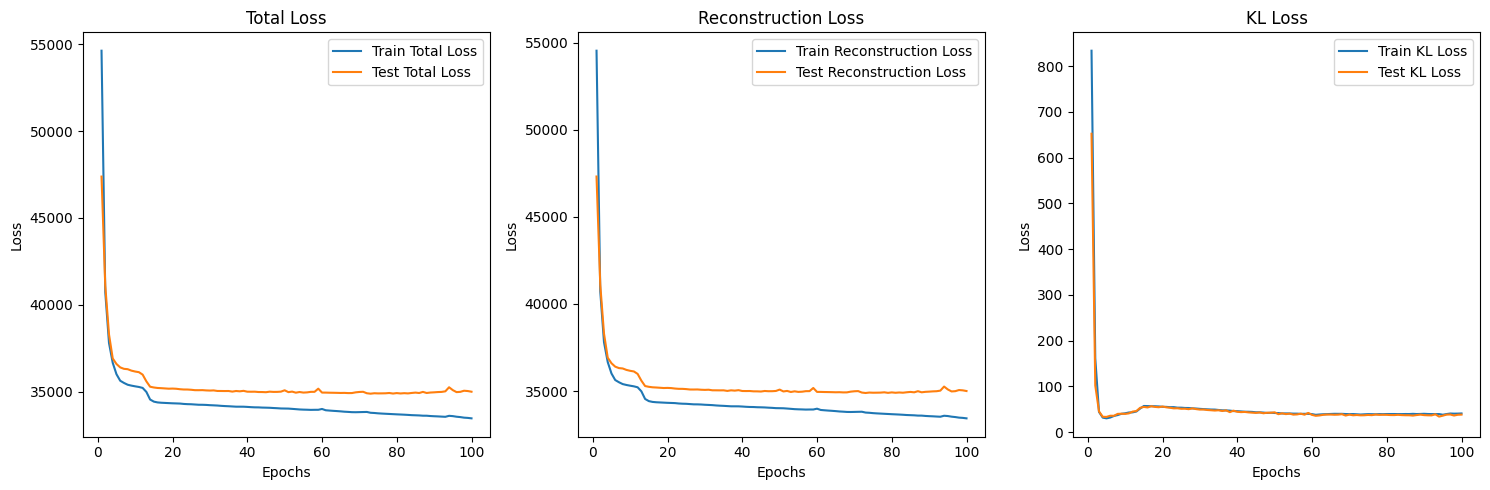

In [ ]:
epochs = range(1, num_epochs + 1)

# Plot
plt.figure(figsize=(15, 5))

# Total Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_total_loss, label='Train Total Loss')
plt.plot(epochs, test_total_loss, label='Test Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Total Loss')
plt.legend()

# Reconstruction Loss
plt.subplot(1, 3, 2)
plt.plot(epochs, train_recon_loss, label='Train Reconstruction Loss')
plt.plot(epochs, test_recon_loss, label='Test Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Reconstruction Loss')
plt.legend()

# KL Loss
plt.subplot(1, 3, 3)
plt.plot(epochs, train_kl_loss, label='Train KL Loss')
plt.plot(epochs, test_kl_loss, label='Test KL Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('KL Loss')
plt.legend()

plt.tight_layout()
plt.show()


Input images
--------------------------------------------------
Reconstructed images
--------------------------------------------------
Generated Images
--------------------------------------------------


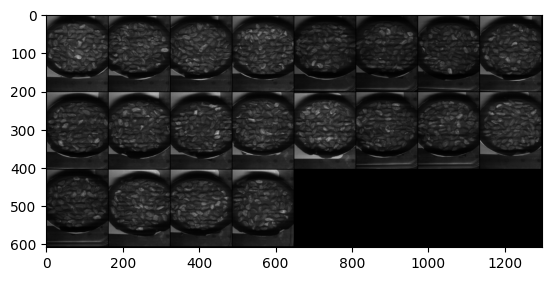

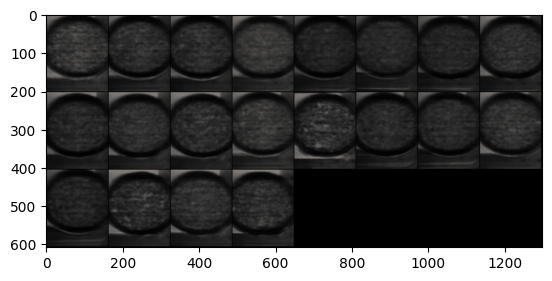

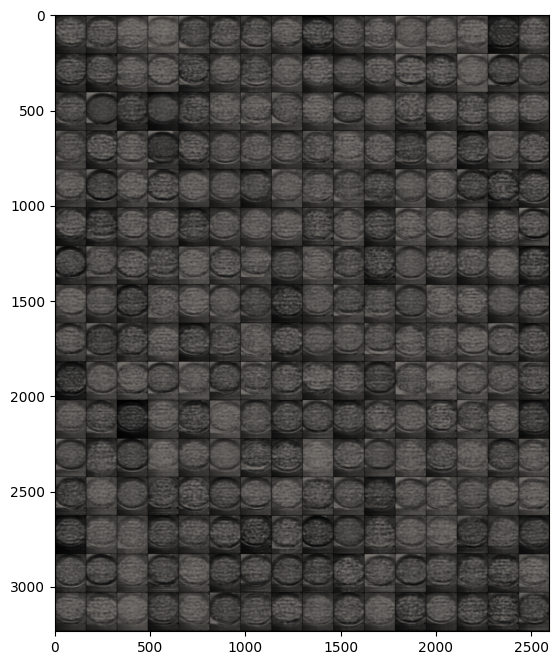

In [ ]:
# Load the model
print('Input images')
print('-'*50)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]
# Visualise the original images of the last batch of the test set
img = make_grid(fixed_input, nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

print('Reconstructed images')
print('-'*50)
with torch.no_grad():
    # Visualise the reconstructed images of the last batch of test set

    recon_batch, _, _ = model(fixed_input.to(device))

    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(recon_batch, nrow=8, padding=2, normalize=False,
                            value_range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)

print('Generated Images')
print('-'*50)
model.eval()
n_samples = 256
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():
    samples = model.decode(z)
    samples = samples.cpu()
    samples = make_grid(samples, nrow=16, padding=2, normalize=False,
                            value_range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)



Input images
--------------------------------------------------
Reconstructed images
--------------------------------------------------
Generated Images
--------------------------------------------------


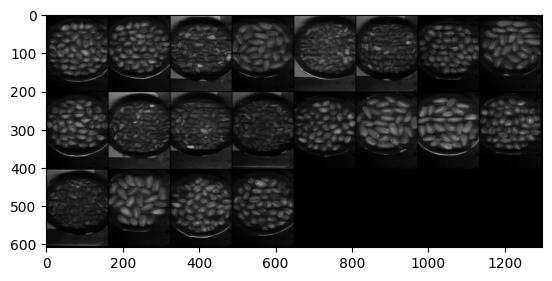

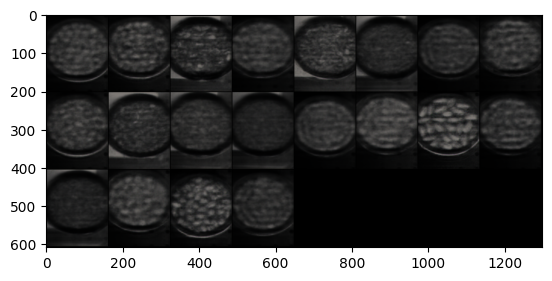

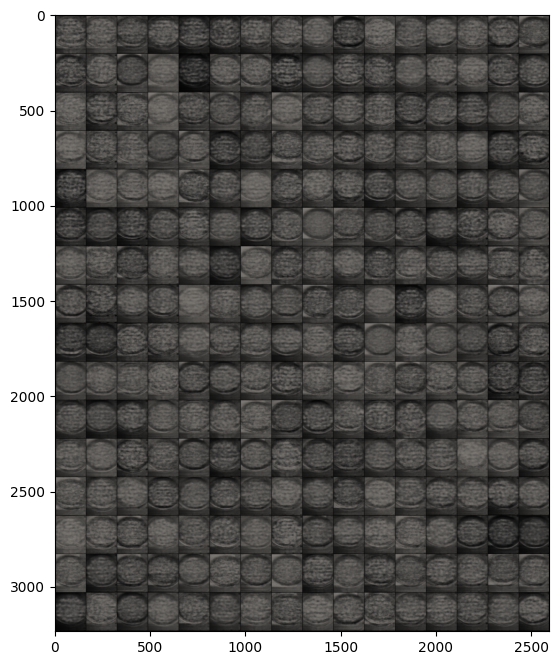

In [ ]:
# Load the model
print('Input images')
print('-'*50)

sample_inputs, _ = next(iter(loader_train))
fixed_input = sample_inputs[0:32, :, :, :]
# Visualise the original images of the last batch of the test set
img = make_grid(fixed_input, nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

print('Reconstructed images')
print('-'*50)
with torch.no_grad():
    # Visualise the reconstructed images of the last batch of test set
    recon_batch, _, _ = model(fixed_input.to(device))

    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(recon_batch, nrow=8, padding=2, normalize=False,
                            value_range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)

print('Generated Images')
print('-'*50)
model.eval()
n_samples = 256
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():
    samples = model.decode(z)
    samples = samples.cpu()
    samples = make_grid(samples, nrow=16, padding=2, normalize=False,
                            value_range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)




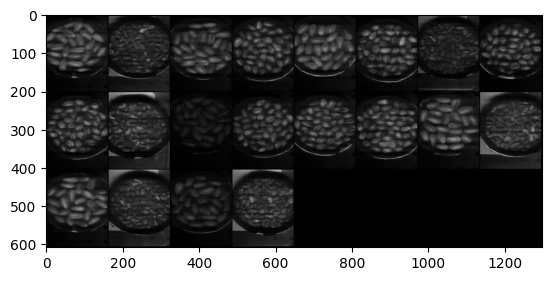

In [ ]:
sample_inputs, _ = next(iter(loader_train))
img = make_grid(sample_inputs, nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

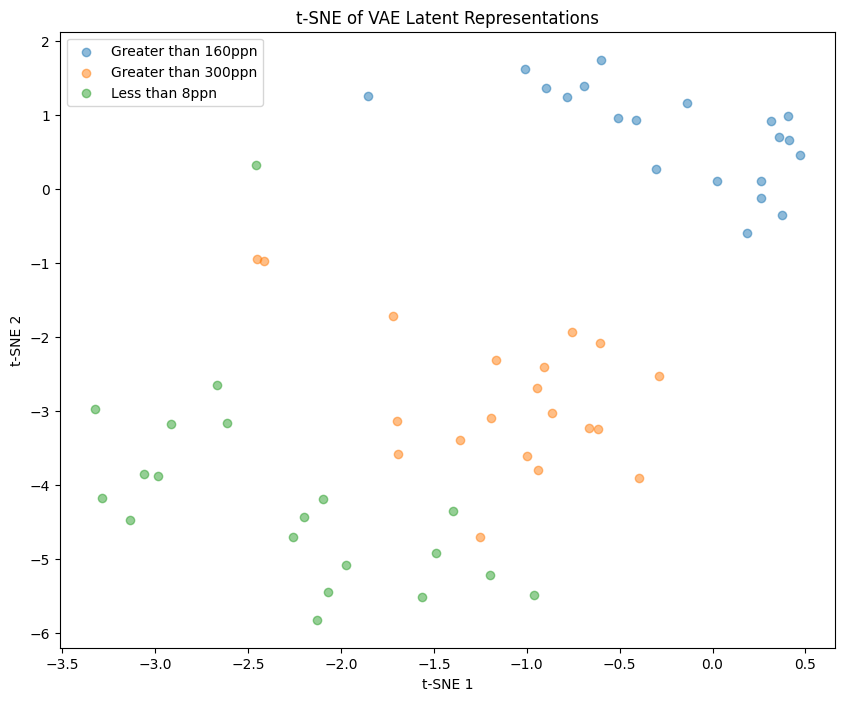

In [ ]:
model.eval()

# Extract latent representations
latents = []
labels = []
with torch.no_grad():
    for data, target in loader_test:
        data = data.to(device)
        mu, _ = model.encode(data)
        latents.append(mu.cpu().numpy())
        labels.append(target.numpy())

# Concatenate all batches
latents = np.concatenate(latents, axis=0)
labels = np.concatenate(labels, axis=0)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
z_embedded = tsne.fit_transform(latents)
classes = ['Greater than 160ppn', 'Greater than 300ppn', 'Less than 8ppn',]
# Plotting
plt.figure(figsize=(10, 8))
for i in range(3):
    idxs = labels == i
    plt.scatter(z_embedded[idxs, 0], z_embedded[idxs, 1], label=classes[i], alpha=0.5)
plt.legend()
plt.title('t-SNE of VAE Latent Representations')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

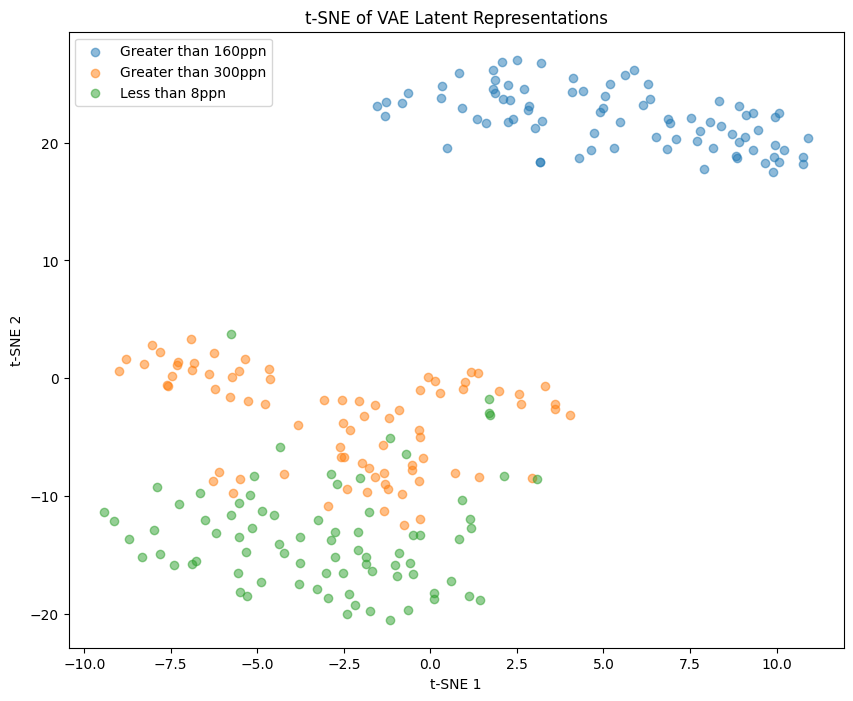

In [ ]:
model.eval()

# Extract latent representations
latents = []
labels = []
with torch.no_grad():
    for data, target in loader_train:
        data = data.to(device)
        mu, _ = model.encode(data)
        latents.append(mu.cpu().numpy())
        labels.append(target.numpy())

# Concatenate all batches
latents = np.concatenate(latents, axis=0)
labels = np.concatenate(labels, axis=0)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
z_embedded = tsne.fit_transform(latents)
classes = ['Greater than 160ppn', 'Greater than 300ppn', 'Less than 8ppn',]
# Plotting
plt.figure(figsize=(10, 8))
for i in range(3):
    idxs = labels == i
    plt.scatter(z_embedded[idxs, 0], z_embedded[idxs, 1], label=classes[i], alpha=0.5)
plt.legend()
plt.title('t-SNE of VAE Latent Representations')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()